# Z1 Data RnD
## Properties-based-Properties Colaborative Filtering Algorithm

We are trying to find an algorithm that can solve our problems. the problem is we want an algorithm that can define similar items. However, in terms of similarity there's usually being like _"Similar Items based on **anything**"_. Mostly, Data Scientist always define the similarity based on user information/behaviors.

With our problem, we are not defining item similarity based on user information. This is the challanges that we are over-thinkig about that. instead of user information we found that we can also do this by **scoring the items**. So that, the senario to do is firstly we need to change the category values to numeric representing as Matrix by using **CountVectorizer**, and then we will be able to perform any Cosine Similarity to determine which items is the most similar. this similarities are also representing as Matrix.

_Let us go through implementation of the Algorithm._

### 1. Import required Libraries

In [51]:
#import Essential Libraries
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### 2. Dataset
_Import the data from Postgre Database for training. The dataset is (10 columns and 100 rows)_

In [52]:
# Point to Postgre Database and Assign as a variable
con = psycopg2.connect(
            host = "192.168.22.131",
            database="Z1_Cloud_Backup",
            user = "postgres",
            password = "Z1@$2020")
cur = con.cursor()

# Define sql Statement and Execute and Assign as a var named data
cur.execute('''-- from database: Z1_Cloud_Backup
select 
----------------------------
-- fields that describe the unique properties
row_number() over(order by last_sync_modify) - 1 as index, id as property_id,
created_at date, concat(concat(latitude, ', '), longitude) as latlong,
----------------------------
record_type, type, current_use, land_shape_type, site_position, -- categories of properties
----------------------------
-- need one more field that represents the prices of properties
----------------------------
-- if width is less than or equal to 6 >>>  'Small Width'
-- if width is greater than 6 until 12 >>> 'Medium'
-- if else >>> 'Large Width'
case when building_width <= 6 then 'Small Width' 
	when building_width <= 12 then 'Medium Width' else 'Large Width' end as width_ranges,
----------------------------
-- if length is less than or equal to 11 >>>  'Small Length'
-- if length is greater than 6 until 12 >>> 'Medium Length'
-- if else >>> 'Large Length'
case when building_length <= 11 then 'Small Length' 
	when building_length <= 16 then 'Medium Length' else 'Large Length' end as length_ranges,
----------------------------
-- listing Fields
is_rent, -- whether the properties are currently opening for rent or not.
is_sale, -- whether the properties are currently opening for sale or not.
is_appraisal, -- whether the properties are already evaluated price or not yet.
----------------------------
-- seperated fields from full_address
split_part(full_address, ',', 5) as address1, -- could be either provinces or dictricts
split_part(full_address, ',', 4) as address2, -- could be either districts or communes
split_part(full_address, ',', 3) as address3  -- could be either communes or villages

from public.properties where created_at > '2022-04-20';''')
data = cur.fetchall()

#create it as a dataframe 
cols = []
for elt in cur.description:
    cols.append(elt[0])
pd.set_option("display.max_columns", None)
properties = pd.DataFrame(data = data, columns = cols)
properties.head(3)

,index,property_id,date,latlong,record_type,type,current_use,land_shape_type,site_position,width_ranges,length_ranges,is_rent,is_sale,is_appraisal,address1,address2,address3
0,0,439222,2022-04-20 08:21:00,"11.50482200, 104.93565100",Land and Building,Residential Property,Terraced House (Flat House),Rectangle,Intermediate Lot,Small Width,Medium Length,False,False,True,Mean Chey,Chak Angrae Kraom,Tuol Roka Bei
1,1,439228,2022-04-20 09:13:04,"11.49082600, 104.94028700",Land and Building,Residential Property,Detached House ( Villa ),L-Shape,Corner Lot,Medium Width,Medium Length,False,False,True,Ta Khmau,Doeum Mien,Doeum Kor
2,2,439231,2022-04-20 09:22:48,"11.84377400, 105.39605800",Land,Vacant Land,Improved Land,Rectangle,Intermediate Lot,Large Width,Large Length,False,False,True,Kaoh Soutin,Lve,Tumpoung


### 3. Missing Values

In [53]:
# view info of dataframe
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051 entries, 0 to 3050
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            3051 non-null   int64         
 1   property_id      3051 non-null   int64         
 2   date             3051 non-null   datetime64[ns]
 3   latlong          3051 non-null   object        
 4   record_type      3048 non-null   object        
 5   type             3047 non-null   object        
 6   current_use      2875 non-null   object        
 7   land_shape_type  2904 non-null   object        
 8   site_position    2904 non-null   object        
 9   width_ranges     3051 non-null   object        
 10  length_ranges    3051 non-null   object        
 11  is_rent          3051 non-null   bool          
 12  is_sale          3051 non-null   bool          
 13  is_appraisal     3051 non-null   bool          
 14  address1         3047 non-null   object 

**Seeing that the dataset has 10 columns** representing as the following:

- **_index_** is representing as row numbers that counting from 0. 
- **_property_id_** represents the unique id of each property.
- **_latlong_** represents the measurement numbers of latitude and longitude.
- _**record_type**, **type**, and **current_use**_ are the _categorical fileds_ representing the types of each property. _record_type_ is the first priority, _type_ is the second priority, and the _current_use_ is the third priority. 
- _**land_shape_type**_ shows the shape of those properties which is launched in the dataset. Those shapes are such as _Rectangle_, _Irregular_, _Square_, or _Triangle_, etc. 
- _**site_position**_ is another columns representing position of properties' site. For instance, is it staying at Corner Lot or others? 
- **_width_ranges_** and **_length_ranges_** is the ranges of building width and length.
- _**is_rent** and **is_sale**_ are showing as binary values in which those properties are for rent or for sale, or for both of rent and sale.
- **_is_appraisal_** is also showing binary values in which those properties are evaluated or not.
- **_address1_**, **_address2_**, and **_address3_** are telling us about the addresses such as provinces/cities, distincts/communes, and also vilages. 

**In this section**, we will face with _Missing Values_ and _Features Combination_.

<AxesSubplot:>

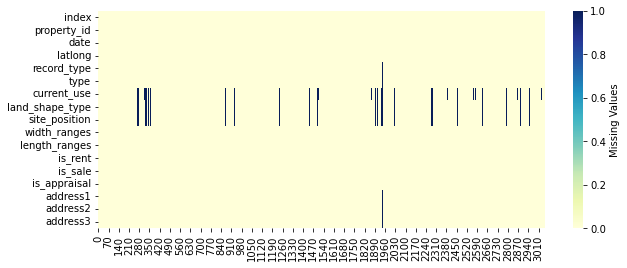

In [54]:
# plot the Heatmap to visualize the missing values
plt.figure(figsize=(10,4))
sns.heatmap(properties.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Values'})

The dataset has some missing values in 8 columns. However, we would happen to fillna in those columns such as _**address1**, **address2**, **address3**, **record_type**, **type**,**current_use**, **land_shape_type**, **site_position**, **is_rent**, **is_sale** and **is_apprasial**_. we do this, becuase we want to prevent other missing vales when we deploy the algorithm. Let's try to do this by filling the missing values with `Others` for categorical fields, `''` for address fields, and `False` values for boolean fields.

In [55]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051 entries, 0 to 3050
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            3051 non-null   int64         
 1   property_id      3051 non-null   int64         
 2   date             3051 non-null   datetime64[ns]
 3   latlong          3051 non-null   object        
 4   record_type      3048 non-null   object        
 5   type             3047 non-null   object        
 6   current_use      2875 non-null   object        
 7   land_shape_type  2904 non-null   object        
 8   site_position    2904 non-null   object        
 9   width_ranges     3051 non-null   object        
 10  length_ranges    3051 non-null   object        
 11  is_rent          3051 non-null   bool          
 12  is_sale          3051 non-null   bool          
 13  is_appraisal     3051 non-null   bool          
 14  address1         3047 non-null   object 

In [56]:
# fill categorical fields by "Others" in missing values
properties[["record_type",
                "type",
                "current_use",
                "land_shape_type",
                "site_position"]] = properties[["record_type",
                                                "type",
                                                "current_use",
                                                "land_shape_type",
                                                "site_position"]].fillna("Others")
# fill "False" into missing values of boolean fields
properties[["is_rent",
                "is_sale",
                "is_appraisal"]] = properties[["is_rent",
                                               "is_sale",
                                               "is_appraisal"]]. fillna("False")
# fill '' in missing values of address
properties[["address1","address2","address3"]] = properties[["address1","address2","address3"]]. fillna('')
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051 entries, 0 to 3050
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            3051 non-null   int64         
 1   property_id      3051 non-null   int64         
 2   date             3051 non-null   datetime64[ns]
 3   latlong          3051 non-null   object        
 4   record_type      3051 non-null   object        
 5   type             3051 non-null   object        
 6   current_use      3051 non-null   object        
 7   land_shape_type  3051 non-null   object        
 8   site_position    3051 non-null   object        
 9   width_ranges     3051 non-null   object        
 10  length_ranges    3051 non-null   object        
 11  is_rent          3051 non-null   bool          
 12  is_sale          3051 non-null   bool          
 13  is_appraisal     3051 non-null   bool          
 14  address1         3051 non-null   object 

Now, there's no more missing values in our dataset. So that we can concat all values of each column, representing as a new column named **_categories_**

In [57]:
# concat all columns and include as a new column named categories
def combined_features(row):
    return str(row['record_type'])+" "+str(row['type'])+" "+str(row['current_use'])+" "+str(row['land_shape_type'])+" "+str(row['site_position'])+" "+str(row['width_ranges'])+" "+str(row['length_ranges'])+" "+str(row['is_rent'])+" "+str(row['is_sale'])+" "+str(row['is_appraisal'])+" "+str(row['address1'])+" "+str(row['address2'])+" "+str(row['address3'])

properties["categories"] = properties.apply(combined_features, axis =1)
properties["categories"]

0       Land and Building Residential Property Terrace...
1       Land and Building Residential Property Detache...
2       Land Vacant Land Improved Land Rectangle Inter...
3       Land Vacant Land Improved Land Rectangle Inter...
4       Land Vacant Land Improved Land Rectangle Inter...
                              ...                        
3046    Land and Building Residential Property Terrace...
3047    Building Condominium Others Others Others Larg...
3048    Land Vacant Land Improved Land Rectangle Inter...
3049    Land and Building Residential Property Terrace...
3050    Land and Building Residential Property Terrace...
Name: categories, Length: 3051, dtype: object

The new column named categories is representing values as text. However, the model cannot be smoothly calculated if the documents still contain operators. To do this, we are next going to remove all operators in the column _categories_.  

In [58]:
# import regular Expression operation
import re

# define a function for removing operators.
def remove_operators(categories):
    return re.sub("[^a-zA-Z0-9 ]", "", categories)
properties["categories"] = properties["categories"].apply(remove_operators)
properties["categories"]

0       Land and Building Residential Property Terrace...
1       Land and Building Residential Property Detache...
2       Land Vacant Land Improved Land Rectangle Inter...
3       Land Vacant Land Improved Land Rectangle Inter...
4       Land Vacant Land Improved Land Rectangle Inter...
                              ...                        
3046    Land and Building Residential Property Terrace...
3047    Building Condominium Others Others Others Larg...
3048    Land Vacant Land Improved Land Rectangle Inter...
3049    Land and Building Residential Property Terrace...
3050    Land and Building Residential Property Terrace...
Name: categories, Length: 3051, dtype: object

### 4. Count Vectorizer the values of listing

_Let's see the sample of Count-Vectorizer. This method trys to count the numbers of terms or words in each document as representing in the following;_

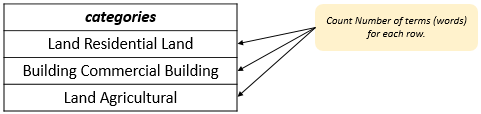

_It then generates as below;_

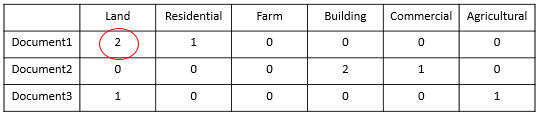

For interpretation, there are two words of Land in the document1, so that the Count-Vectorizer counts this word and and represent as number 2. and so on.

In [59]:
# count number terms, generate as metrix, and assign as a variable
cv = CountVectorizer()
matrix = cv.fit_transform(properties["categories"])
print(matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### 5. Cosine Similarities

_Let's also see the sample of Cosine Similarity. The Cosine Similarity trys to calculate the percentages of similarities between each document_.

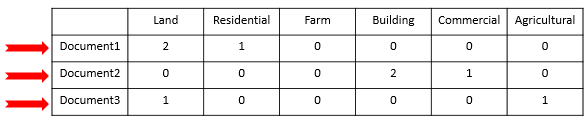

_The calculation is calculated by comparing between two-by-two vectors. As showing below, This is the comparison between document1 and document2._ 

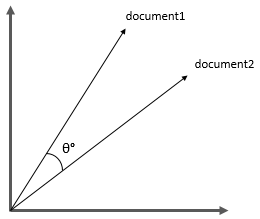

_The calculation of cosine similarity above is calculated based on its formula as representing below;_

`Cos(x, y) = x . y / ||x|| * ||y||`

where 
- x . y = product (dot) of the vectors ‘x’ and ‘y’.
- ||x|| and ||y|| = length of the two vectors ‘x’ and ‘y’.
- ||x|| * ||y|| = cross product of the two vectors ‘x’ and ‘y’.

In [60]:
#call the variable of matrix to calculate by Cosine Similarity
properties_similar_scores = cosine_similarity(matrix)

# represent as matrix of similar properties.
print(properties_similar_scores)

[[1.         0.55745196 0.43357427 ... 0.36430604 0.76709295 0.70967742]
 [0.55745196 1.         0.37293493 ... 0.3086067  0.57635398 0.49186938]
 [0.43357427 0.37293493 1.         ... 0.75331778 0.44827586 0.40022241]
 ...
 [0.36430604 0.3086067  0.75331778 ... 1.         0.37665889 0.33394721]
 [0.76709295 0.57635398 0.44827586 ... 0.37665889 1.         0.73374108]
 [0.70967742 0.49186938 0.40022241 ... 0.33394721 0.73374108 1.        ]]


As the result, the algorithm generates scores of property similarities as Matrix, meaning that it compares properties to properties themselves. Let's see the figure below to make more understanding.

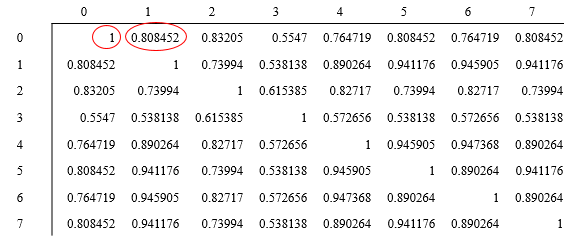

Between property0 and property0 are the same property, so that it's equal to 1, meaning that 100% of similarity between two of these. And between property1 and property0 there are a similar score about 80.84%. And so on. 

### 6. Recommendation top-similar properties

This is the input value of current_use that's input when users have viewed. Assume that, Roeun Apireak has viewed a property in which current_use is 'Improved Land'. So that, the system inputs the value 'Improved Land' into our Algorithm in a variable name `current_use_user_viewed`.

In [61]:
current_use_user_viewed = "Improved Land"

let's create a function called `get_index_from_current_use` this function can be called for retrive a specific index based on the current_use._

In [62]:
# Input [current_use], Output [index] column.
def get_index_from_current_use(current_use):
    return properties[properties.current_use == current_use]["index"].values[0]
property_index = get_index_from_current_use(current_use_user_viewed)
print(property_index)

2


_The function prints out the number 4, meaning that the index of current_use 'Improved Land' is 4._

_**Next**_ is to iterate the similarity scores, and assign it as the farmat 'list'. In this, we will have a variable named `list_similar_properties` which has all indexes of properties with every scores that comparing to the values of `current_use_user_viewed`.

In [63]:
list_similar_properties = list(enumerate(properties_similar_scores[property_index]))

_**And Then**_, Let's sort the scores as descending. you'll see the most similar properties which are similar to value of `current_use_user_viewed`. The list you see below is representing as _[index, Similar Scores]_.

In [64]:
# Sort the list by descending
desc_similar_properties = sorted(list_similar_properties, key=lambda x:x[1], reverse=True)

We are going to create a function that can return such as id and current_use back back from index. 

In [65]:
# define function that return index
def get_current_use_from_id(index):
    index = properties[properties.index == index]["index"].values[0]
    id = properties[properties.index == index]["property_id"].values[0]
    current_use = properties[properties.index == index]["current_use"].values[0]
    print(str(index) +", "+ str(id) +", "+ str(current_use)) # for deployment, this might be error because of data type. 

Using for-loop to return unique properties, and using Break also for determining that we will return only 10 properties which are the most similar to the value of `current_use_users_viewed`.

_The output result you see below are represented as 'index, id, current_use'._

In [66]:
i = 0
for property in desc_similar_properties:
    print(get_current_use_from_id(property[0]))
    i = i + 1
    if i == 10: #Recommend 5 similar properties back to users.
        break

2, 439231, Improved Land
None
935, 445774, Improved Land
None
1012, 445851, Improved Land
None
937, 445777, Improved Land
None
1995, 448148, Improved Land
None
2449, 447383, Improved Land
None
2847, 446979, Improved Land
None
3021, 448189, Improved Land
None
3036, 448175, Improved Land
None
3, 439234, Improved Land
None


**Therefore, our algorithm is now being able to recommend the similar properties to any users who have viewed a specific property.**